In [1]:
import roboticstoolbox as rbt
from spatialmath import *
import numpy as np

In [2]:
pi = np.pi
l1 = 3
l2 = 3

In [3]:
# 3R-R-3R
human_arm = rbt.DHRobot([
        rbt.RevoluteMDH(alpha = pi/2), #joint 1
        rbt.RevoluteMDH(alpha = pi/2, offset = pi/2), #joint 2
        rbt.RevoluteMDH(alpha = -pi/2, offset = -pi/2), #joint 3
        rbt.RevoluteMDH(a = 0.4, alpha = -pi/2, offset = -pi/2), #joint 4
        rbt.RevoluteMDH(alpha = -pi/2, d = 0.4), #joint 5
        rbt.RevoluteMDH(alpha = pi/2, offset = pi/2), #joint 6
        rbt.RevoluteMDH(alpha = pi/2), #joint 7
    ],
    name = "Human Arm"
)
human_arm

DHRobot: Human Arm, 7 joints (RRRRRRR), dynamics, modified DH parameters
┌──────┬────────┬───────────┬─────┐
│ aⱼ₋₁ │  ⍺ⱼ₋₁  │    θⱼ     │ dⱼ  │
├──────┼────────┼───────────┼─────┤
│  0.0 │  90.0° │        q1 │ 0.0 │
│  0.0 │  90.0° │  q2 + 90° │ 0.0 │
│  0.0 │ -90.0° │  q3 - 90° │ 0.0 │
│  0.4 │ -90.0° │  q4 - 90° │ 0.0 │
│  0.0 │ -90.0° │        q5 │ 0.4 │
│  0.0 │  90.0° │  q6 + 90° │ 0.0 │
│  0.0 │  90.0° │        q7 │ 0.0 │
└──────┴────────┴───────────┴─────┘

┌──┬──┐
└──┴──┘

# MoveJ mode

## Forward Kinematics

In [4]:
q = [0,0,0,0,0,0,0]

In [5]:
T_0e = human_arm.fkine(q)
T_0e

   0         0        -1         0         
   0        -1         0         0         
  -1         0         0        -0.8       
   0         0         0         1         


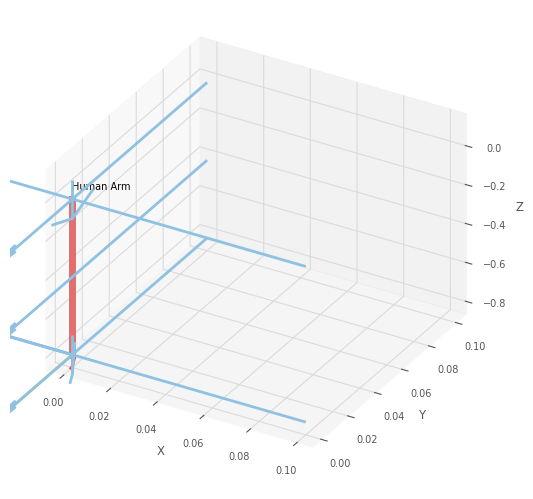

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Human Arm')

<Figure size 640x480 with 0 Axes>

In [6]:
human_arm.plot(q)

## Invert Kinematics

In [7]:
T_goal = SE3(5,1,3) @ SE3.Rx(pi/2)
T_goal

   1         0         0         5         
   0         0        -1         1         
   0         1         0         3         
   0         0         0         1         


In [8]:
q_sol = human_arm.ikine_LM(T_goal)

In [9]:
q_sol

IKSolution(q=array([ 0.59176464,  1.96060021, -2.7990761 , -0.33489993, -1.84468853,
        0.1264097 , -0.70394593]), success=True, iterations=16, searches=1, residual=3.899056967795112e-07, reason='Success')

In [10]:
q_sol.q

array([ 0.59176464,  1.96060021, -2.7990761 , -0.33489993, -1.84468853,
        0.1264097 , -0.70394593])

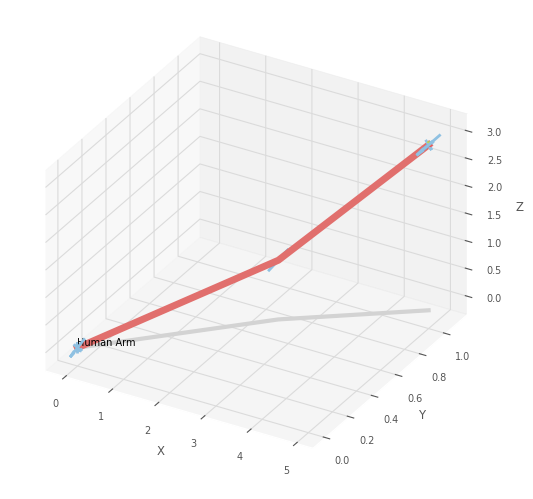

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Human Arm')

<Figure size 640x480 with 0 Axes>

In [11]:
human_arm.plot(q_sol.q)

# MoveL mode

## Velocity calculation

In [31]:
# current_q = [0,0,0.5,0.25,0,0,0]
current_q = [0,0,0,0,0,0,0]
current_q

[0, 0, 0, 0, 0, 0, 0]

### Forward Kinematics

In [32]:
current_pos = human_arm.fkine(current_q)
current_pos

   0         0        -1         0         
   0         1         0         0         
   1         0         0         6         
   0         0         0         1         


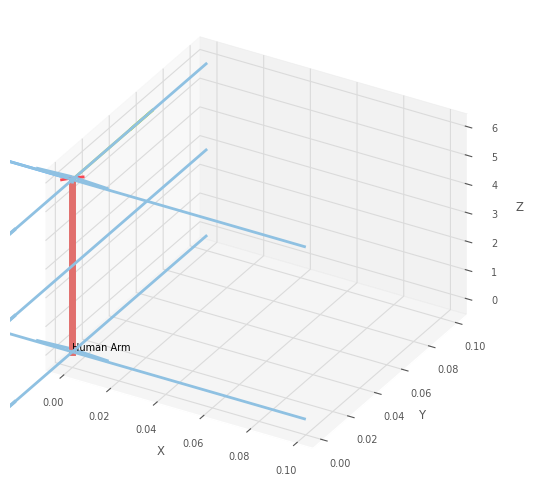

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Human Arm')

<Figure size 640x480 with 0 Axes>

In [33]:
human_arm.plot(current_q)

### Target direction 

In [34]:
target = [5,1,3,0,0,0]
target

[5, 1, 3, 0, 0, 0]

In [35]:
current_pos.rpy()[0]

0.0

In [37]:
target_direction = [
    target[0] - current_pos.x,
    target[1] - current_pos.y,
    target[2] - current_pos.z,
    target[3] - current_pos.rpy()[0], # roll
    target[4] - current_pos.rpy()[1], # pitch
    target[5] - current_pos.rpy()[2] # yall
]
target_direction

[5.0,
 0.9999999999999998,
 -3.0,
 0.0,
 1.5707963267948966,
 -6.123233995736766e-17]

In [38]:
linear_size = np.sqrt(target_direction[0]**2 + target_direction[1]**2 + target_direction[2]**2)
linear_size

5.916079783099616

In [39]:
angular_size = np.sqrt(target_direction[3]**2 + target_direction[4]**2 + target_direction[5]**2)
angular_size

1.5707963267948966

In [40]:
unit_target_direction =[
    target_direction[0] / linear_size,
    target_direction[1] / linear_size,
    target_direction[2] / linear_size,
    target_direction[3] / angular_size,
    target_direction[4] / angular_size,
    target_direction[5] / angular_size,
]
unit_target_direction

[0.8451542547285166,
 0.16903085094570328,
 -0.50709255283711,
 0.0,
 1.0,
 -3.8981718325193755e-17]

In [41]:
vel = [
    unit_target_direction[0] * 0.5,
    unit_target_direction[1] * 0.5,
    unit_target_direction[2] * 0.5,
    unit_target_direction[3] * 0.5,
    unit_target_direction[4] * 0.5,
    unit_target_direction[5] * 0.5,
]

## Jacobian

In [46]:
J = human_arm.jacob0(current_q)
J

array([[-1.83697020e-16, -6.00000000e+00, -3.67394040e-16,
        -3.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.83697020e-16, -2.46519033e-32,  6.00000000e+00,
        -1.23259516e-32,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-3.03535178e-49,  1.83697020e-16, -1.83697020e-16,
         1.23259516e-32,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.00000000e+00],
       [-3.74939946e-33, -1.00000000e+00, -6.12323400e-17,
        -1.00000000e+00, -3.74939946e-33, -1.00000000e+00,
        -6.12323400e-17],
       [ 1.00000000e+00,  6.12323400e-17,  6.12323400e-17,
         6.12323400e-17,  1.00000000e+00,  6.12323400e-17,
         6.12323400e-17]])

In [47]:
Jt = J.transpose()
Jt

array([[-1.83697020e-16,  1.83697020e-16, -3.03535178e-49,
         0.00000000e+00, -3.74939946e-33,  1.00000000e+00],
       [-6.00000000e+00, -2.46519033e-32,  1.83697020e-16,
         0.00000000e+00, -1.00000000e+00,  6.12323400e-17],
       [-3.67394040e-16,  6.00000000e+00, -1.83697020e-16,
        -1.00000000e+00, -6.12323400e-17,  6.12323400e-17],
       [-3.00000000e+00, -1.23259516e-32,  1.23259516e-32,
         0.00000000e+00, -1.00000000e+00,  6.12323400e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -3.74939946e-33,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.00000000e+00,  6.12323400e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.00000000e+00, -6.12323400e-17,  6.12323400e-17]])

In [48]:
Jit = np.linalg.inv(np.dot(J,J.transpose()))
Jit

array([[ 2.22222222e-01,  1.66666667e-01,  5.44374645e+15,
        -1.75020271e-16, -3.33333333e-01,  5.10269500e-18],
       [ 1.66666667e-01,  2.22222222e-01,  5.44374645e+15,
         1.66666667e-01, -1.66666667e-01, -5.10269500e-18],
       [ 5.44374645e+15,  5.44374645e+15,  1.77806253e+32,
        -6.04992921e+00, -5.44374645e+15, -2.55134750e-17],
       [-1.13787931e-16,  1.66666667e-01, -4.04992921e+00,
         1.00000000e+00,  7.29663711e-17,  1.53080850e-17],
       [-3.33333333e-01, -1.66666667e-01, -5.44374645e+15,
         1.34198711e-16,  1.00000000e+00,  1.53080850e-17],
       [ 5.10269500e-18, -5.10269500e-18,  1.34198711e-16,
         1.53080850e-17,  1.53080850e-17,  5.00000000e-01]])

In [49]:
J_new = np.dot(Jt,Jit)
J_new

array([[-5.10269500e-18,  5.10269500e-18,  9.24197836e-17,
         4.59242550e-17,  4.59242550e-17,  5.00000000e-01],
       [-5.55111512e-17,  1.66666667e-01,  5.44374645e+15,
        -1.95431051e-16,  1.11022302e-16, -1.53080850e-17],
       [-1.37130180e-16,  1.66666667e-01, -1.56393174e+00,
        -1.11022302e-16,  1.41150633e-16, -1.53080850e-17],
       [-3.33333333e-01, -3.33333333e-01, -1.08874929e+16,
         3.90862102e-16, -5.55111512e-16,  6.16297582e-33],
       [ 5.10269500e-18, -5.10269500e-18,  1.54609491e-16,
         1.53080850e-17,  1.53080850e-17,  5.00000000e-01],
       [ 3.33333333e-01,  1.66666667e-01,  5.44374645e+15,
        -1.34198711e-16, -1.00000000e+00,  1.53080850e-17],
       [ 1.34198711e-16, -1.66666667e-01,  4.38326254e+00,
        -1.00000000e+00, -1.34198711e-16,  1.53080850e-17]])

## Calculate q_dot

In [50]:
q_dot = np.dot(J_new,vel)
q_dot

array([-1.19410199e-17, -1.38024164e+15,  4.10614973e-01,  2.76048328e+15,
       -3.95670221e-17, -1.38024164e+15, -1.12544580e+00])

## Find singularity

In [55]:
import numpy as np
from scipy.linalg import svd

# Compute singular values
U, S, Vh = svd(J)
print("Singular values:", S)

# Check for near-zero singular values
if np.any(S < 1e-6):
    print("Jacobian is near singular.")
else:
    print("Jacobian is non-singular.")


Singular values: [6.84451016e+00 6.08504366e+00 1.41421356e+00 1.07362968e+00
 9.86024149e-01 4.09684666e-17]
Jacobian is near singular.


## Calculate joint effort

In [27]:
w = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
w

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [29]:
t = np.dot(J.transpose(),w)
t

array([-2.57405257, -6.9258615 ,  1.35180893, -4.31208182,  1.06741805,
       -0.39815702, -1.3046416 ])